# A gentle intro to the important bits of Mxnet and Gluon

Learn the basics of Mxnet and Gluon. How the define by run style makes definition of differentiable blocks simpler, how to use existing pretrained models, and how it makes debugging with pdb possible.

Additional material to talk "Differentiable programming in Python and Gluon for (not only medical) image analysis." by Jan Margeta on PyCon SK 2018

- https://github.com/jmargeta/PyConSK2018
- https://twitter.com/jmargeta/
- https://kardio.me/

In [1]:
%pylab inline
import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon import nn
from mxnet.test_utils import download
import pdb
import scipy
from scipy.misc import face
mx.__version__

Populating the interactive namespace from numpy and matplotlib


'1.1.0'

# Arrays in MxNet

Found in mxnet.ndarray or simply mxnet.nd

## To create:

In [2]:
nd_from_initializer = nd.zeros(shape=(4, 2, 3), ctx=mx.cpu())
nd_from_random = nd.random.uniform(-1, 1, ctx=mx.cpu())
nd_from_arr = nd.array([[1, 2, 3]], ctx=mx.cpu())
nd_from_numpy = nd.array(np.random.uniform(low=-1, high=1, size=(4, 4)), ctx=mx.cpu())

To get back the numpy array

In [3]:
nd_from_arr.asnumpy()

array([[ 1.,  2.,  3.]], dtype=float32)

## Device context
- can specify device which will be used to store variables and used for the computations
- for example mx.cpu(), mx.gpu(0) (for NVidia GPUs), can be also a list [mx.gpu(0), mx.gpu(1)]
- to switch context and copy (if needed) between devices - array.as_in_context(new_context)



In [4]:
mxnet_ndarray = nd.ones(shape=(2, 3, 4), ctx=mx.cpu())
print(mxnet_ndarray.context)
print(mxnet_ndarray.as_in_context(mx.cpu()))

cpu(0)

[[[ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]]

 [[ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]
  [ 1.  1.  1.  1.]]]
<NDArray 2x3x4 @cpu(0)>


## Operations just like numpy

In [5]:
x = nd.ones(shape=(2, 3, 4), ctx=mx.cpu())
y = nd.sin(x)
z = nd.exp(y)

# Two interfaces to MxNet

## Symbolic - define & run
Similar to Theano, Tensorflow and others where computational graphs are first constructed.
Symbolic and imperative have in most of the cases identical interface.

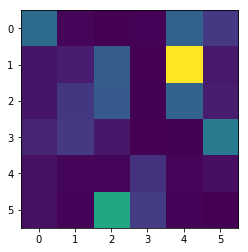

In [6]:
# define
x = mx.sym.Variable('x')
y = x ** 2

# run
executor = y.bind(ctx=mx.cpu(), args={'x': mx.nd.random.normal(shape=(6, 6), ctx=mx.cpu())})
out = executor.forward()
plt.imshow(out[0].asnumpy())

## Imperative - define by run

**Similar to numpy**, accessible via mxnet.ndarray or simply mxnet.nd.
Arrays also have context - where they are stored CPU/GPUs

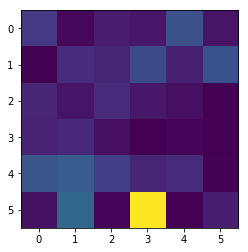

In [7]:
# define by run
x = mx.nd.random.normal(shape=(6, 6), ctx=mx.cpu())
y = x ** 2

plt.imshow(y.asnumpy())

# Shapes are automatically computed

In [8]:
conv = gluon.nn.Conv2D(16, kernel_size=(3, 3), padding=(1, 1))
conv.collect_params().initialize()
print(conv(nd.zeros((1, 3, 256, 256))).shape)
print(conv(nd.zeros((4, 3, 128, 128))).shape)

(1, 16, 256, 256)
(4, 16, 128, 128)


In [9]:
dense = gluon.nn.Dense(16)
dense.collect_params().initialize()
print(dense(nd.zeros((10, 128, 256))).shape)
print(dense(nd.zeros((5, 128, 256))).shape)

(10, 16)
(5, 16)


# Computing derivatives with autograd

One of the most important aspects of a modern ML library is the ability to automatically compute derivatives.

Derivative measures how much a value of a function (return value) changes with respect to a change in its parameter.
The derivative also tells us, how we should change the parameter so that the return value of the function increases (or decreases if we look in the oposite direction of the gradient).

For example:
$y(x) = cos(x)$ 

The rate of change of $y(x)$ with respect to a change in $x$ is:
$\frac{\partial y(x)}{\partial x} = -sin(x)$

For common functions, there are already [existing tables with derivatives](https://en.wikipedia.org/wiki/Derivative).

However, there is no need for that with Gluon which provides an autograd.
All that is needed is to call attach_grad() on each variable with respect to which we will need derivatives and then to wrap the computation into mxnet.autograd.record().
This way, all computation is recorded and the computational graph is defined by run.

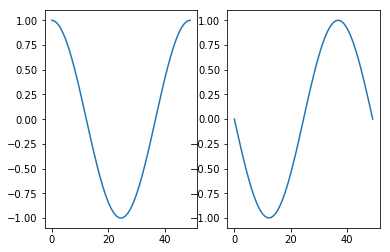

In [10]:
x = nd.array(np.linspace(0, 2*np.pi))
x.attach_grad()

with mx.autograd.record():
    y = nd.cos(x)
y.backward()

fig, axes = plt.subplots(1, 2)
axes[0].plot(y.asnumpy())
axes[1].plot(x.grad.asnumpy());

For more flexibility, this can be also written as

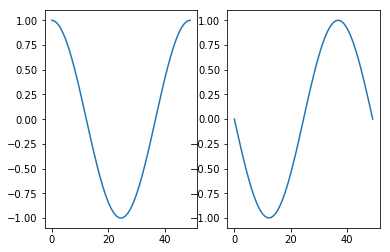

In [11]:
orig_training = mx.autograd.is_training()
mx.autograd.set_recording(True)
mx.autograd.set_training(True)
y = nd.cos(x)
mx.autograd.set_recording(False)
mx.autograd.set_training(orig_training)

y.backward()

fig, axes = plt.subplots(1, 2)
axes[0].plot(y.asnumpy())
axes[1].plot(x.grad.asnumpy());

## Loops and control flow are ok!

In [12]:
def funky_function(a):
    b = a * 2
    while (nd.norm(b) < 10).asscalar():
        b = b ** 2
    if (mx.nd.sum(b) > 1).asscalar():
        c = b
    else:
        c = 10 * b
    return c

a = nd.random_normal(shape=3)
a.attach_grad()

with mx.autograd.record():
    c = funky_function(a)
c.backward()
print(a.grad)


[ -1.94211149  20.8663559  -13.25249577]
<NDArray 3 @cpu(0)>


Try to do anything similar in tensorflow...

## And of course that autograd works for functions of multiple variables

Finding minimum of a function means moving in the direction oposite to the gradient.

Here is a functon $z(x, y) = (x - 5)^2 + (y - 10)^2$ with two arguments $x$ and $y$.
Its minumum (the darkest spot on the top left image)is at x=5 and y = 10

To get closer to miminum from any point x, or y, we should move in the direction oposite to:
$\frac{\partial}{\partial x} z(x, y) = 2 * x$
$\frac{\partial}{\partial y} z(x, y) = 2 * y$

In other words update the current position $(x, y)$ as $x := x - 2 * x$ and  $y := y - 2 * y$

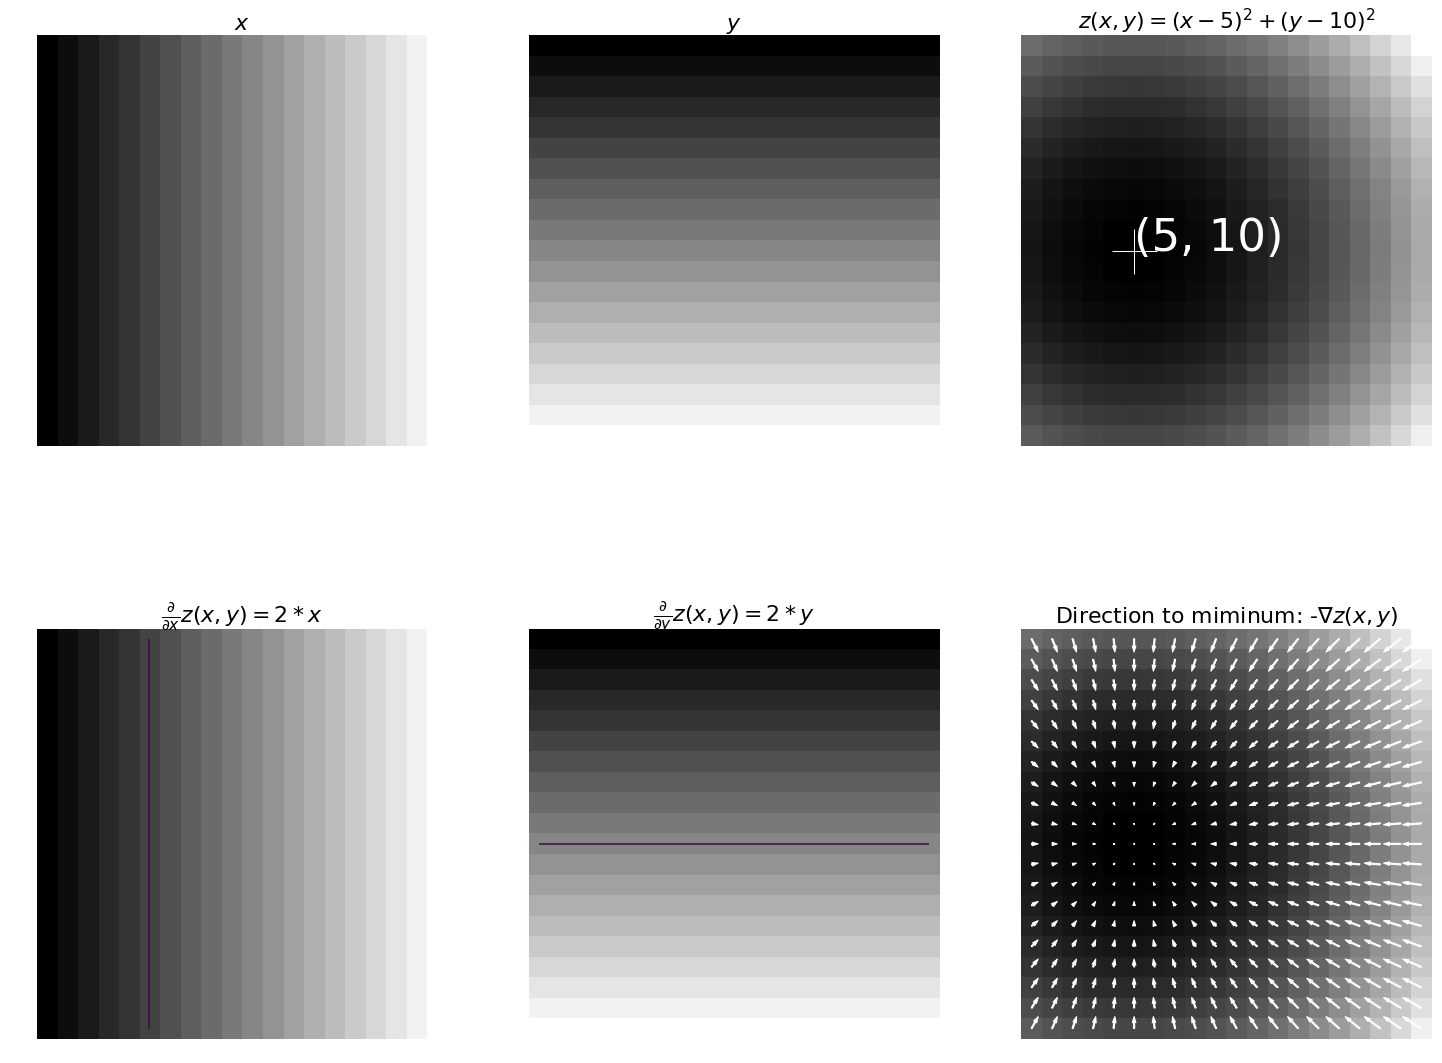

In [13]:
yy, xx = np.indices((20, 20))
x = nd.array(xx)
y = nd.array(yy)
x.attach_grad()
y.attach_grad()

with mx.autograd.record():
    z = (x - 5) ** 2 + (y - 10) ** 2
z.backward()

fig, axes = plt.subplots(2, 3, figsize=(25, 20))
axes[0, 0].imshow(x.asnumpy(), cmap='gray')
axes[0, 0].set_title('$x$', fontsize=22)
axes[0, 1].imshow(y.asnumpy(), cmap='gray')
axes[0, 1].set_title('$y$', fontsize=22)
axes[0, 2].imshow(z.asnumpy(), cmap='gray')
axes[0, 2].set_title('$z(x, y)= (x - 5)^2 + (y - 10)^2$', fontsize=22)
axes[0, 2].plot(5, 10, '+', color='w', markersize=45)
axes[0, 2].text(5, 10, '(5, 10)', color='w', fontsize=45)

axes[1, 0].imshow(x.grad.asnumpy(), cmap='gray')
axes[1, 0].contour(x.grad.asnumpy(), levels=[0])
axes[1, 0].set_title(r'$\frac{\partial}{\partial x} z(x, y) = 2 * x$', fontsize=22)
axes[1, 1].imshow(y.grad.asnumpy(), cmap='gray')
axes[1, 1].contour(y.grad.asnumpy(), levels=[0])
axes[1, 1].set_title(r'$\frac{\partial}{\partial y} z(x, y) = 2 * y$', fontsize=22)
axes[1, 2].quiver(xx, yy, -x.grad.asnumpy(), -y.grad.asnumpy(), angles='xy', edgecolor='w', facecolor='white', linewidth=1)
axes[1, 2].imshow(z.asnumpy(), cmap='gray')
axes[1, 2].set_title(r'Direction to miminum: -$\nabla z(x, y)$', fontsize=22)

for ax in axes.ravel():
    ax.set_axis_off()

# Defining custom functions for autograd

Not every function is written with mxnet and available to autograd. So sometimes a wrapper is needed.
This might even allow to combine Gluon with other frameworks (e.g. with pytorch).

In [14]:
class Multiply(mx.autograd.Function):
    def forward(self, x, y):
        self.save_for_backward(x, y)      
        return x * y

    def backward(self, dz):
        x, y = self.saved_tensors
        return [y * dz, x * dz]
    

x = nd.array(np.linspace(0, 2))
x.attach_grad()
y = nd.array(np.linspace(0, 4))
y.attach_grad()

multiplier = Multiply()

with mx.autograd.record():
    z = multiplier(x, y)
z.backward()

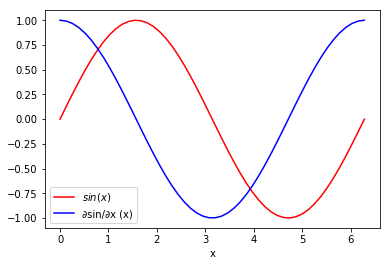

In [15]:
class Sin(mx.autograd.Function):
    def forward(self, x):
        self.save_for_backward(x)
        y_np = np.sin(x.asnumpy())
        return mx.nd.array(y_np, ctx=x.context)

    def backward(self, dy):
        x, = self.saved_tensors
        y_np = np.cos(x.asnumpy())
        return dy * mx.nd.array(y_np, ctx=x.context)
    
sin = Sin()
x = nd.array(np.linspace(0, 2*np.pi))
x.attach_grad()

with mx.autograd.record():
    y = sin(x)
y.backward()

plt.plot(x.asnumpy(), y.asnumpy(), 'r', label='$sin(x)$')
plt.plot(x.asnumpy(), x.grad.asnumpy(), 'b', label='∂sin/∂x (x)');
plt.xlabel('x')
plt.legend();

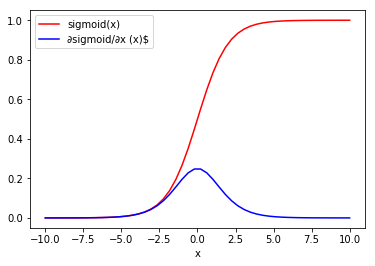

In [16]:
class Sigmoid(mx.autograd.Function):
    def forward(self, x):
        y = 1 / (1 + mx.nd.exp(-x))
        self.save_for_backward(y)
        return y

    def backward(self, dy):
        # backward takes as many inputs as forward's return value,
        # and returns as many NDArrays as forward's arguments.
        y, = self.saved_tensors
        return dy * y * (1 - y)
    
    
sigmoid = Sigmoid()

x = nd.array(np.linspace(-10, 10))
x.attach_grad()
with mx.autograd.record():
    y = sigmoid(x)
y.backward()

plt.plot(x.asnumpy(), y.asnumpy(), 'r', label='sigmoid(x)')
plt.plot(x.asnumpy(), x.grad.asnumpy(), 'b', label='∂sigmoid/∂x (x)$');
plt.xlabel('x')
plt.legend()

# Feel free to combine them anyhow you like

 - even with mxnet.ndarray functions
 - with loops, branching, and whatever is needed

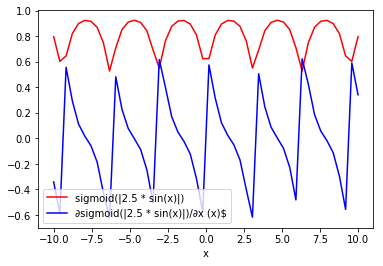

In [17]:
sigmoid = Sigmoid()
sin = Sin()

x = nd.array(np.linspace(-10, 10))
x.attach_grad()

with mx.autograd.record():
    z = 2.5 * sin(x)
    z = nd.abs(z)
    y = sigmoid(z)

y.backward()

plt.plot(x.asnumpy(), y.asnumpy(), 'r', label='sigmoid(|2.5 * sin(x)|)')
plt.plot(x.asnumpy(), x.grad.asnumpy(), 'b', label='∂sigmoid(|2.5 * sin(x)|)/∂x (x)$');
plt.xlabel('x')
plt.legend()

# Basic building blocks

Often it is useful to combine computation into useful blocks (e.g. image recognition block, preprocessing block, sentiment analysis block...).

Gluon offers several possible classes to help with this.
No need to specify input sizes, these are computed and set on first evaluation.

## Hybrid sequential
Just like Keras... stack layers sequentially

In [18]:
net = gluon.nn.HybridSequential()
net.add(nn.Conv2D(3, kernel_size=5, padding=2)) # operation on image that outputs 3 channels
net.add(nn.Conv2D(6, kernel_size=5, padding=2)) # operation on previous 3 channel image that outputs 6 channels
net.add(nn.Flatten()) # make a vector - be careful, this could be large!
net.add(nn.Dense(12)) # this could be very expensive if the input vector is large

## Hybrid block
Preserve some state in init, and then do whatever you want in hybrid_forward.
Looping, control flow, even recursion if desired... but that one cannot be used with symbols.

In [19]:
class IterativeProcessingBlock(gluon.nn.HybridSequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.add(nn.Conv2D(3, kernel_size=5, padding=2))
            self.add(nn.Conv2D(3, kernel_size=5, padding=2))

In [20]:
class RecursiveProcessingNet(gluon.nn.HybridBlock):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.recurser = nn.Conv2D(3, kernel_size=5, padding=2)

    def hybrid_forward(self, F, x, depth):
        if depth > 0 and x.mean() > 10:
            x = self.hybrid_forward(F, x, depth - 1)
        else:
            return x

In [21]:
class BigNet(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.convin = nn.Conv2D(3, kernel_size=5, padding=2)
            self.iterative_process = IterativeProcessingBlock(prefix='iterative_')
            self.convpreout = nn.Conv2D(3, kernel_size=5, padding=2)
            self.convout = nn.Conv2D(6, kernel_size=5, padding=2)

    def hybrid_forward(self, F, x):
        x = x_in = self.convin(x)
        for _ in range(2):
            x = self.iterative_process(x)
        x = F.concat(x_in, self.convpreout(x), dim=1)
        x = self.convout(x)    
        return x
    
net = BigNet()

## Do not forget to initialize the parameters before running the net, e.g. with random numbers...

In [22]:
net.collect_params().initialize(mx.init.Uniform())

In [23]:
arr = mx.nd.zeros((1, 1, 100, 100), ctx=mx.cpu(), dtype=np.float32)
y = net(arr)
y.shape

(1, 6, 100, 100)

# Making the computational graph symbolic

This can be useful when exporting the model for deployment.

In [24]:
x = mx.sym.Variable('x')
y = net(x)

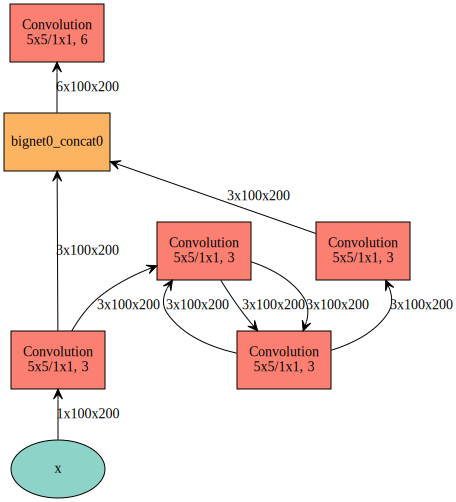

In [25]:
graph = mx.viz.plot_network(y, shape={'x':(1, 1, 100,200)}, node_attrs={"fixedsize":"false"})
graph.format = 'svg'
graph.render('graph')
from IPython.display import SVG, display
def show_svg():
    display(SVG(filename='graph.svg'))
show_svg()

# Hybridization

Once all the model works well enough, it is simple to obtain further execution speed gains.

Gluon allows to switch between faster to experiment with define by run interface and compiled define and run.
A way to compile the graph and also skip the Python interpreter

In [26]:
from mxnet import gluon

class Net(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            self.fc1 = nn.Dense(256)
            self.fc2 = nn.Dense(128)
            self.fc3 = nn.Dense(2)

    def hybrid_forward(self, F, x):
        # F is a function space that depends on the type of x
        # If x's type is NDArray, then F will be mxnet.nd
        # If x's type is Symbol, then F will be mxnet.sym
        print('type(x): {}, F: {}'.format(
                type(x).__name__, F.__name__))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [27]:
net = Net()
net.collect_params().initialize()
x = nd.random_normal(shape=(1, 512))
print('1st forward')
y = net(x)
print('2nd forward')
y = net(x)

1st forward
type(x): NDArray, F: mxnet.ndarray
2nd forward
type(x): NDArray, F: mxnet.ndarray


The graph is compiled only once, on the second run the compiled version is run (ignoring any statements that did not contribute to the result such as the print)

In [28]:
net = Net()
net.collect_params().initialize()
net.hybridize()
x = nd.random_normal(shape=(1, 512))
print('1st forward')
y = net(x)
print('2nd forward')
y = net(x)

1st forward
type(x): Symbol, F: mxnet.symbol
2nd forward


## Hybridization can lead to significant speedups

In [29]:
from mxnet import gluon

class BenchNet(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.fc1 = nn.Dense(256)
            self.fc2 = nn.Dense(128)
            self.fc3 = nn.Dense(2)

    def hybrid_forward(self, F, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [30]:
net = BenchNet()
net.collect_params().initialize()

In [31]:
%%timeit 
y = net(x)
nd.waitall()

309 µs ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
net.hybridize()

In [33]:
%%timeit 
y = net(x)
nd.waitall()

129 µs ± 9.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Using pretrained models in the model zoo

Gluon has a rich collection of defined and pretrained state of the art models
https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html

Many are trained from scratch or transformed from PyTorch models.
Scripts for training are availble.

## Image recognition with state of the art models

 - for most of the models that contain Dense layers, the input size will have to be the same as when the model was trained

In [34]:
download('https://static.pexels.com/photos/12526/pexels-photo-12526.jpeg', fname='test_image.jpeg')

'test_image.jpeg'

In [35]:
ctx = mx.cpu()
image_recognizer = mx.gluon.model_zoo.vision.mobilenet1_0(pretrained=True, ctx=ctx)
input_shape = (224, 224)

Source image intensity range <0, 255>
Source image shape (2704, 4365, 3)
Normalized image intensity range <-2.1179039478302, 2.640000104904175>
Normalized image shape (2704, 4365, 3)


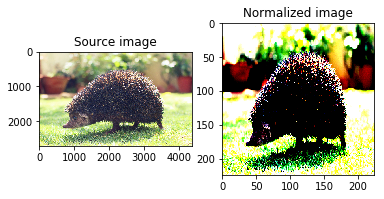

In [36]:
im_test = mx.image.imread('./test_image.jpeg')

im_normalized = mx.image.color_normalize(
    im_test.astype(np.float32) / 255.0,
    mean=mx.nd.array([0.485, 0.456, 0.406]),
    std=mx.nd.array([0.229, 0.224, 0.225]))

im_resized = mx.gluon.data.vision.transforms.Resize((224, 224))(im_normalized)
input_tensor = im_resized.transpose((2, 0, 1)).expand_dims(0)
predicted = image_recognizer(input_tensor)

print('Source image intensity range <{}, {}>'.format(im_test.min().asscalar(), im_test.max().asscalar()))
print('Source image shape', im_test.shape)
print('Normalized image intensity range <{}, {}>'.format(im_normalized.min().asscalar(), im_normalized.max().asscalar()))
print('Normalized image shape', im_normalized.shape)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_test.asnumpy())
ax[0].set_title('Source image')
ax[1].imshow(im_resized.asnumpy())
ax[1].set_title('Normalized image');

map the predictions to class names

In [37]:
download('https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt')

with open('imagenet_classes.txt', 'r') as fp:
    imagenet_classes = [line.strip() for line in fp.readlines()]

Top 5 predictions (class probabilities and class names):
0.882 	 porcupine, hedgehog
0.026 	 echidna, spiny anteater, anteater
0.025 	 Irish water spaniel
0.021 	 bison
0.014 	 wild boar, boar, Sus scrofa


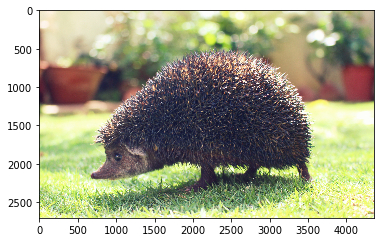

In [38]:
top_5_classes = np.argsort(predicted[0].asnumpy())[-5:]
probabilities = nd.softmax(predicted[0])

print('Top 5 predictions (class probabilities and class names):')
for i, class_idx in enumerate(top_5_classes[::-1]):
    proba = (probabilities[int(class_idx)].asscalar())
    class_name = imagenet_classes[class_idx]
    print('{:0.3f} \t {}'.format(proba, class_name))
    
plt.imshow(im_test.asnumpy());

# Extract intermediate features from images
 - if we are interested only in convolutional features that are computed before any dense layers, then it is possible to pass in an image of any input size

In [39]:
resized = im_normalized[::4, ::4] # subsample the image 4x for less memory usage and faster computations
input_tensor = resized.transpose((2, 0, 1)).expand_dims(0)

In [40]:
source_net = mx.gluon.model_zoo.vision.mobilenet0_25(pretrained=True, prefix='model_', ctx=ctx)

# Select which inputs to the network we want to use
inputs = mx.sym.Variable('x')

# Select which layers are we interested in as outputs - in this case the convolutional ones
net_outputs = source_net(inputs)
internals = net_outputs.get_internals()
selected_outputs = [
    internals[output] for output in internals.list_outputs()
    if ('conv' in output) and ('fwd_output' in output)
]

feature_extractor = gluon.SymbolBlock(selected_outputs, inputs, params=source_net.collect_params())
features = feature_extractor(input_tensor)

### Extracted features:

0 - (1, 8, 338, 546)
1 - (1, 8, 338, 546)
2 - (1, 16, 338, 546)
3 - (1, 16, 169, 273)
4 - (1, 32, 169, 273)
5 - (1, 32, 169, 273)
6 - (1, 32, 169, 273)
7 - (1, 32, 85, 137)
8 - (1, 64, 85, 137)
9 - (1, 64, 85, 137)
10 - (1, 64, 85, 137)
11 - (1, 64, 43, 69)
12 - (1, 128, 43, 69)
13 - (1, 128, 43, 69)
14 - (1, 128, 43, 69)
15 - (1, 128, 43, 69)
16 - (1, 128, 43, 69)
17 - (1, 128, 43, 69)
18 - (1, 128, 43, 69)
19 - (1, 128, 43, 69)
20 - (1, 128, 43, 69)
21 - (1, 128, 43, 69)
22 - (1, 128, 43, 69)
23 - (1, 128, 22, 35)
24 - (1, 256, 22, 35)
25 - (1, 256, 22, 35)
26 - (1, 256, 22, 35)


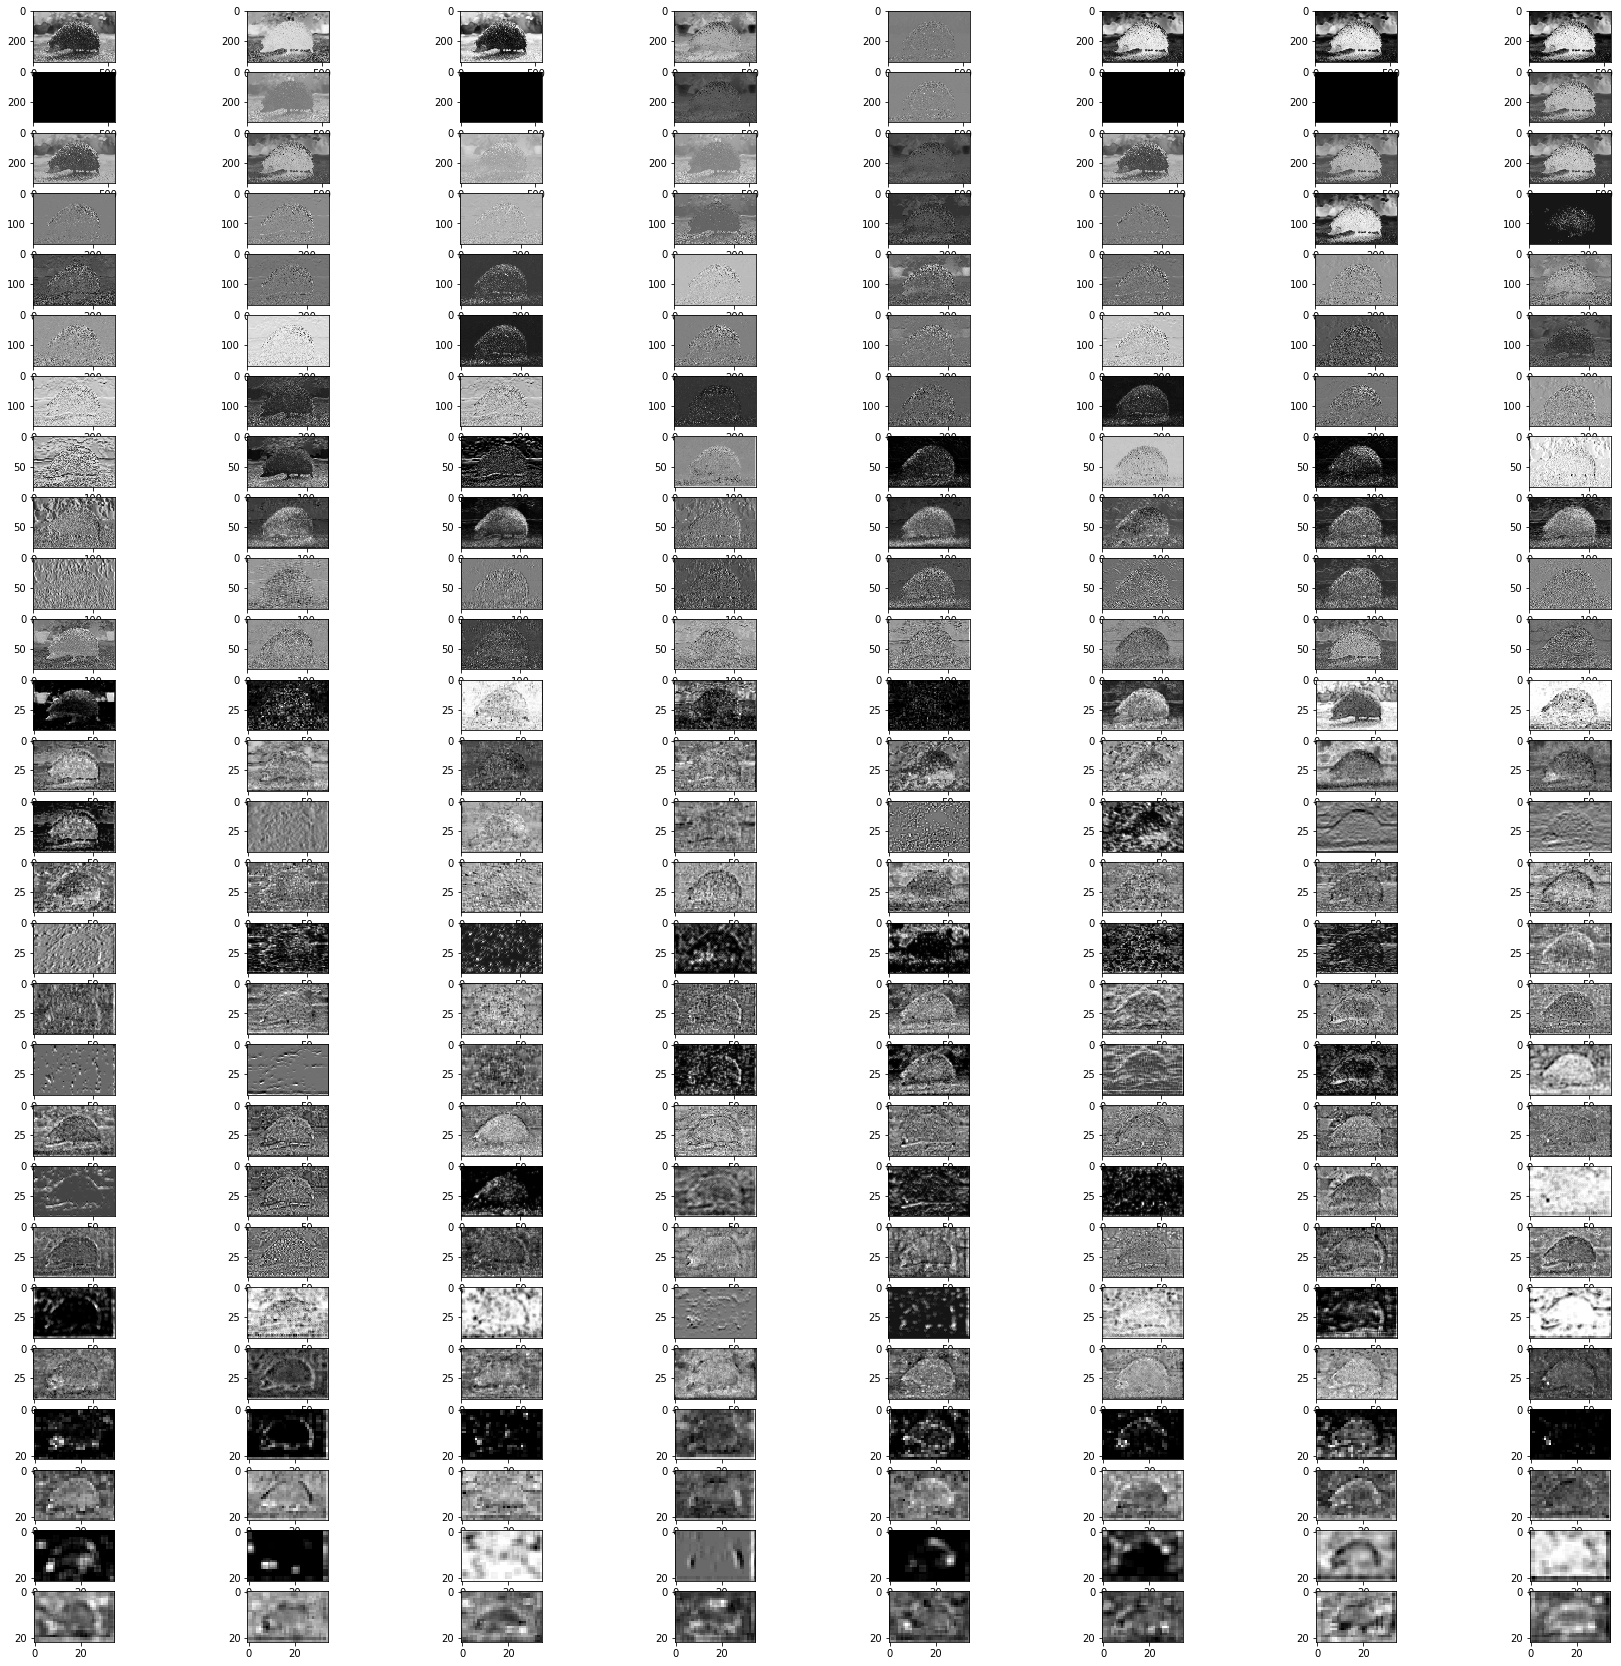

In [41]:
for idx, layer in enumerate(features):
    print('{} - {}'.format(idx, layer.shape))

NUM_CHANNELS_PER_LAYER = 8
fig, axes = plt.subplots(len(features), NUM_CHANNELS_PER_LAYER, figsize=(30, 30))
for feature_channels, axes_in_layer in zip(features, axes):
    for ax, channel in zip(axes_in_layer, feature_channels[0]):
        ax.imshow(channel.asnumpy(), cmap='gray')

# Other advantages of imperative - define by run style

Code behaves like you would expect from Python code.
The best is probably to extract all potentially trainable parameters (even in the non ML preprocessing code) and wrap the functionality into blocks.

# Immediate errors
Having an imperative interface allows you to catch errors immediately and not hidden in some execution engine error log.

In [42]:
nd.dot(nd.zeros(shape=3), nd.zeros(shape=2))

MXNetError: [14:30:24] src/operator/tensor/./dot-inl.h:998: Check failed: lshape[0] == rshape[0] (3 vs. 2) dot shape error: [3] X [2]

Stack trace returned 10 entries:
[bt] (0) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x276938) [0x7f69246e9938]
[bt] (1) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x276d48) [0x7f69246e9d48]
[bt] (2) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x8b084b) [0x7f6924d2384b]
[bt] (3) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24733c2) [0x7f69268e63c2]
[bt] (4) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24757e9) [0x7f69268e87e9]
[bt] (5) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x23b6ceb) [0x7f6926829ceb]
[bt] (6) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(MXImperativeInvokeEx+0x63) [0x7f692682a283]
[bt] (7) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f6987b3ce40]
[bt] (8) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x2eb) [0x7f6987b3c8ab]
[bt] (9) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2cf) [0x7f6987d5095f]



In [43]:
class ErrorNet(gluon.Block):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.conv1 = gluon.nn.Conv2D(4, kernel_size=(3, 3))
            self.fc1 = gluon.nn.Dense(128)
            self.conv2 = gluon.nn.Conv2D(8, kernel_size=(3, 3))

    def forward(self, x):
        x = self.conv1(x)
        # a flattening is missing here!
        x = self.fc1(x)
        return self.conv2(x)

error_net = ErrorNet()
error_net.collect_params().initialize()

error_net(nd.zeros((1, 1, 200, 200)))

infer_shape error. Arguments:
  data: (1, 128)


MXNetError: Error in operator errornet0_conv1_fwd: [14:31:41] src/operator/nn/./convolution-inl.h:492: Check failed: dshp.ndim() == 4U (2 vs. 4) Input data should be 4D in batch-num_filter-y-x

Stack trace returned 10 entries:
[bt] (0) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x276938) [0x7f69246e9938]
[bt] (1) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x276d48) [0x7f69246e9d48]
[bt] (2) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x44a6a0) [0x7f69248bd6a0]
[bt] (3) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x25eab07) [0x7f6926a5db07]
[bt] (4) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x244274f) [0x7f69268b574f]
[bt] (5) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x244523f) [0x7f69268b823f]
[bt] (6) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/site-packages/mxnet/libmxnet.so(MXSymbolInferShape+0x1539) [0x7f692683a659]
[bt] (7) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f6987b3ce40]
[bt] (8) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x2eb) [0x7f6987b3c8ab]
[bt] (9) /home/jmargeta/.virtualenvs/PyCon2018-cLn9x2vW/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2cf) [0x7f6987d5095f]



## Debugging works, of course...
Note: type q to quit the debugger

In [44]:
def looper(a):
    for i in range(5):
        a = a ** 2
        if (mx.nd.sum(a) > 1).asscalar():
            pdb.set_trace()
            return a
    return a / 2

a = nd.random_normal(shape=3)
c = looper(a)

> <ipython-input-44-a4eea9a1c39b>(6)looper()
-> return a


BdbQuit: 